In [1]:
import sys
sys.path.append('/home/om2382/mft-theory/')
import numpy as np
import torch
import matplotlib.pyplot as plt
from importlib import reload
from LDR_dim import *
reload(util)

<module 'LDR_dim.util' from '/home/om2382/mft-theory/LDR_dim/util.py'>

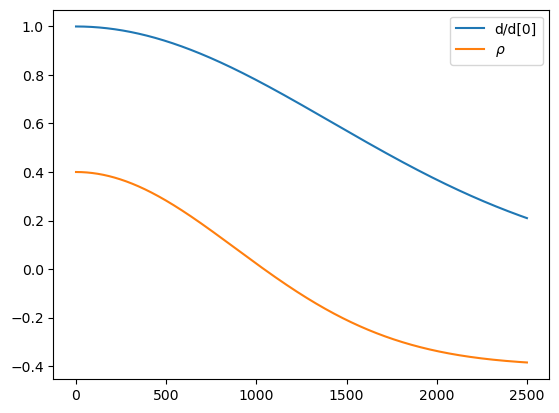

g_eff = 2.8150759450584157


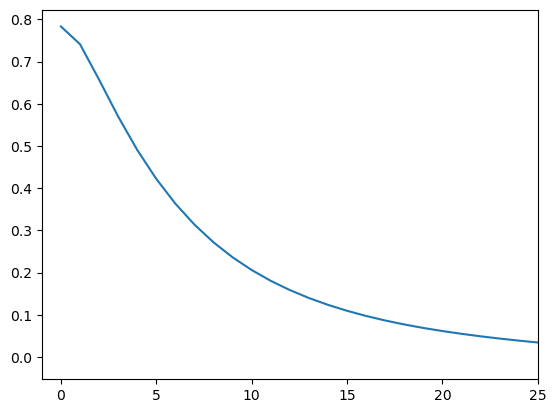

In [2]:
reload(util)

N = 2500

#define d and rho
d = 4*util.gen_spect(N, 0.8, power=2)
rho = 0.8*util.gen_spect(N, 0.5, power=2) - 0.4
plt.plot(d/d[0], label="d/d[0]")
plt.plot(rho, label="$\\rho$")
plt.legend()
plt.show()

#get effective g (determines dynamcis when rho = 0)
print("g_eff =", np.sqrt((d**2).mean().item()))

#sample weights
J = util.gen_LDR(d=d, rho=rho)

#run simulation
X = util.run_sim(
    T=2500, dt=0.05, T_eval=1, J=J.to(0), N_batch=10)

#plot empirical autocov
C = util.compute_C(torch.tanh(X.to(0)), 0).cpu()
plt.plot(C)
plt.xlim(-1, 25)
plt.show()

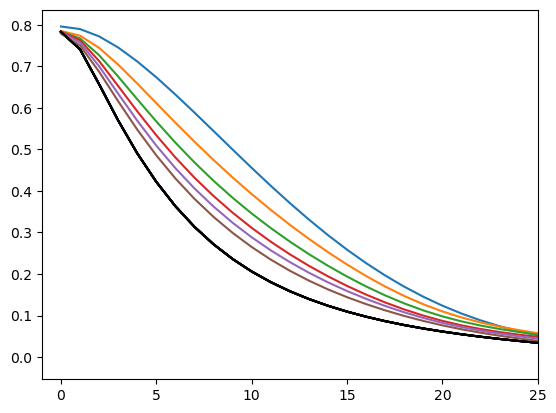

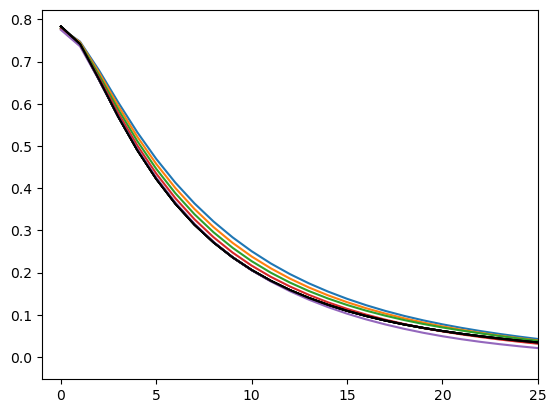

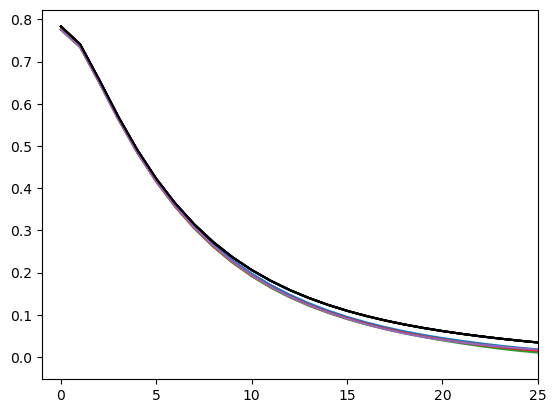

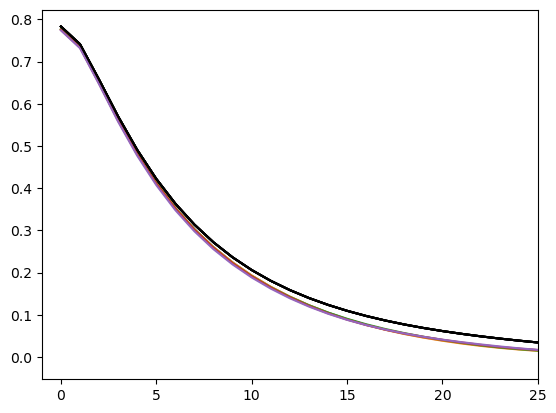

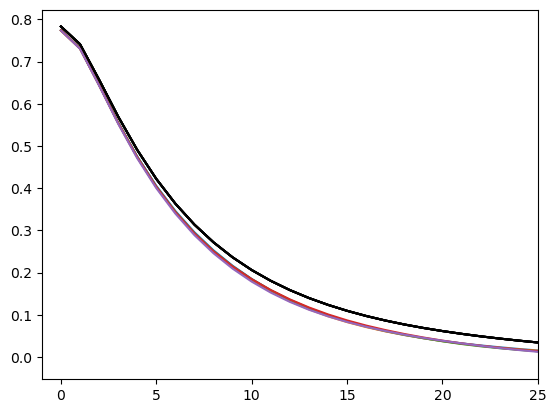

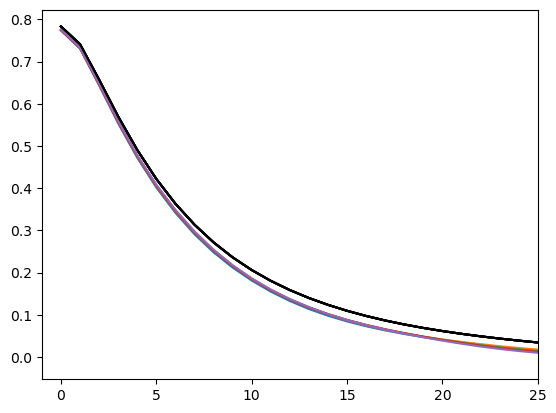

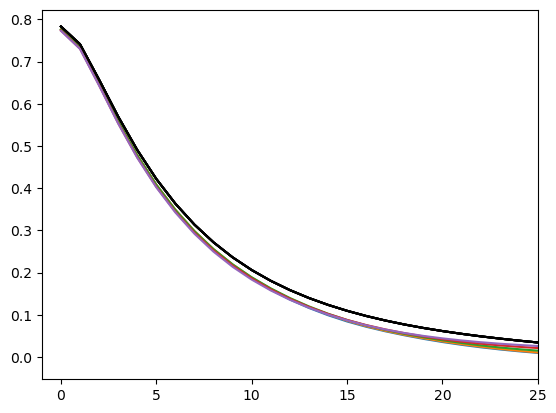

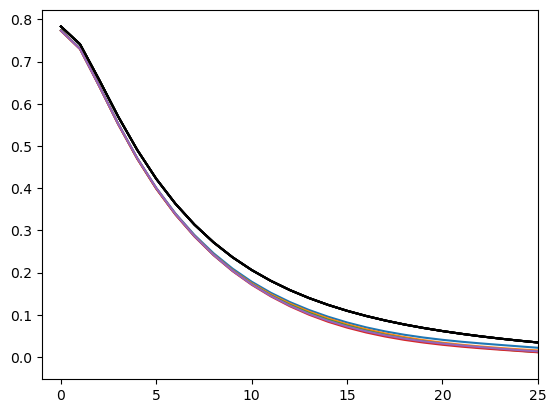

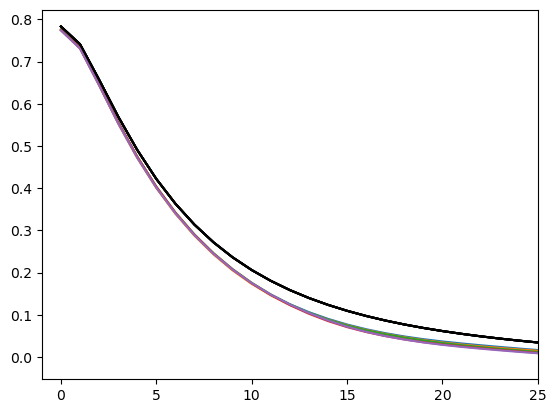

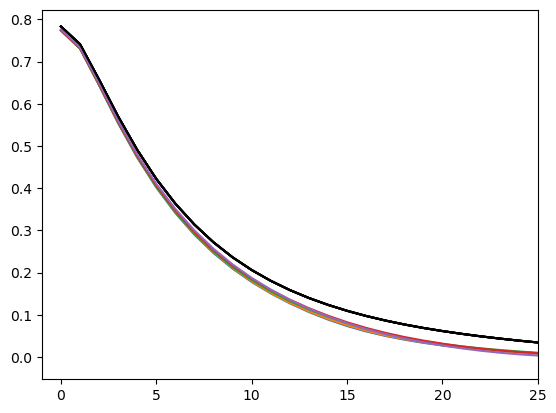

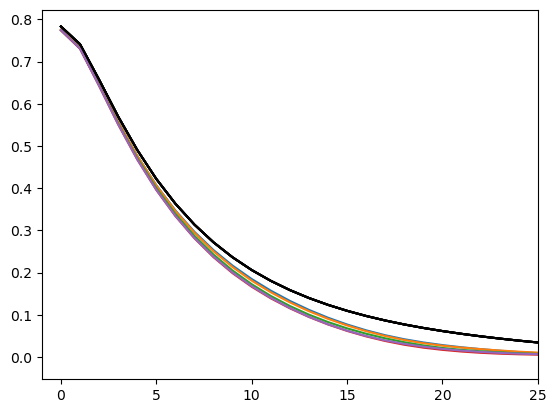

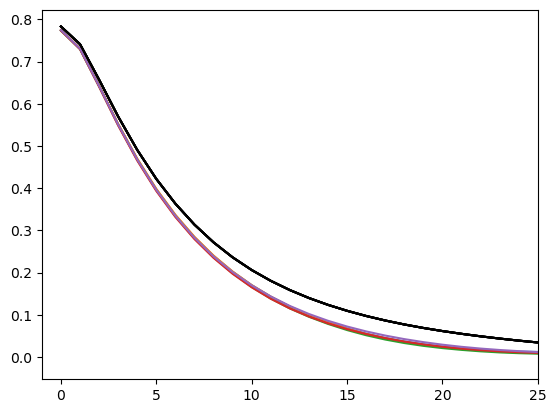

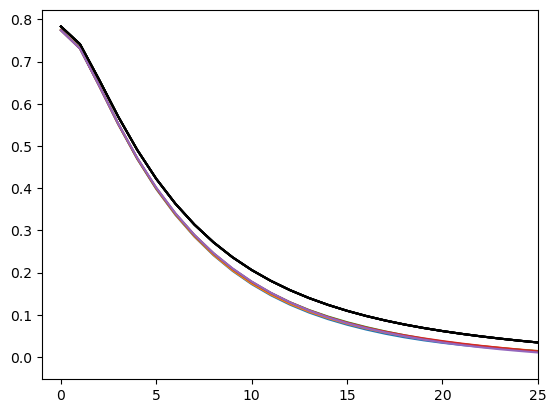

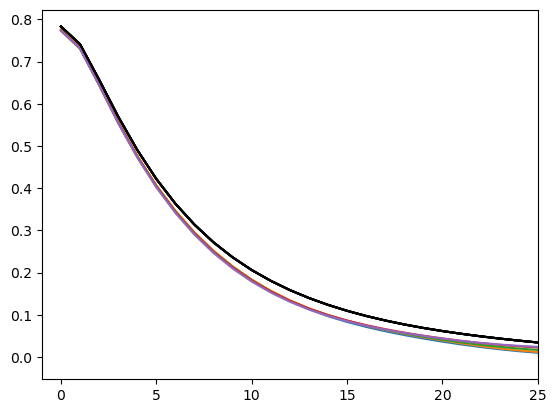

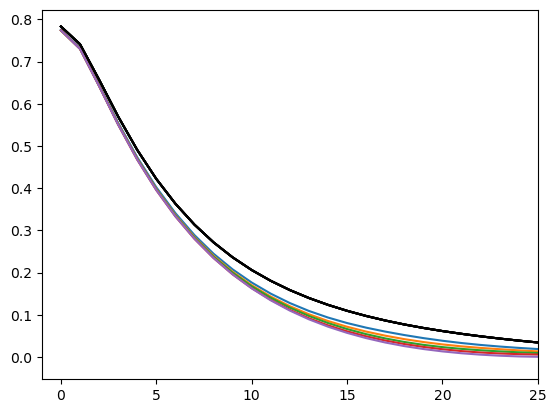

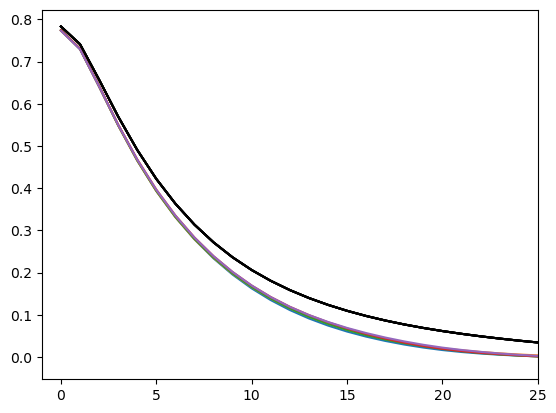

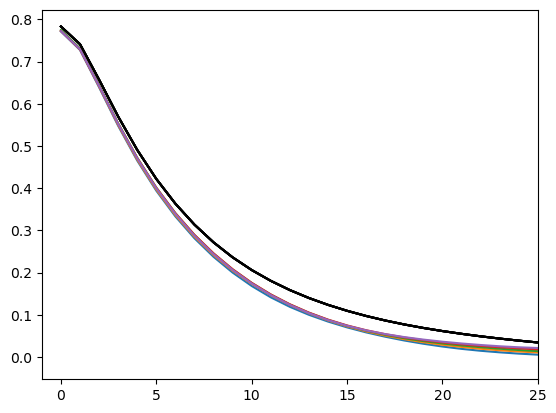

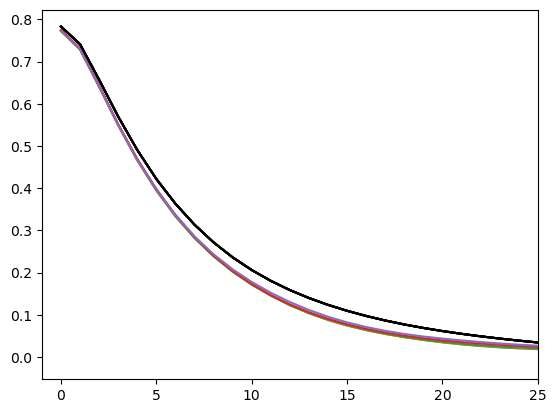

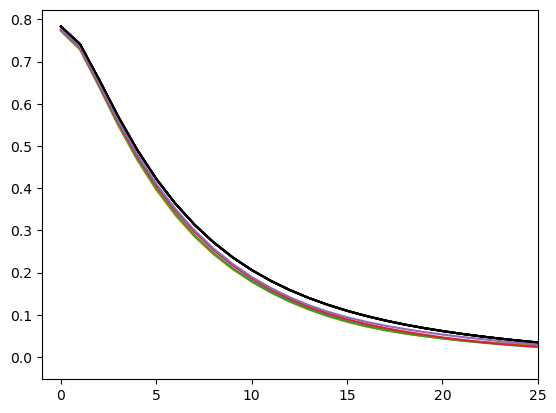

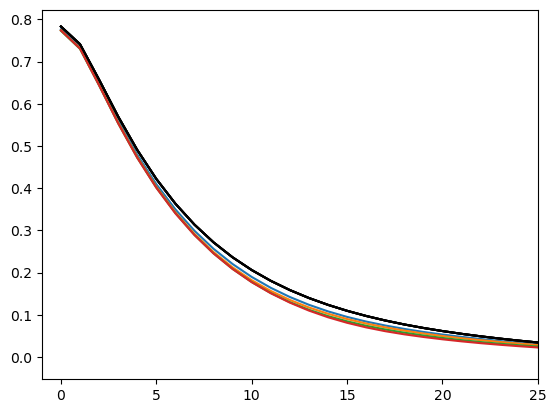

In [3]:
reload(util)

#define callback function for solving LDR DMFT
#(plots current DMFT estimate and empirical estimate in black)
def callback_fn(C_current, S_current, i):
    plt.plot(C_current.cpu()[::20])
    plt.plot(C, color='black')
    plt.xlim(-1, 25)
    if i >= 1 and i % 5 == 0:
        plt.show()

#run DMFT solver loop
dt = 0.05
C_dmft, S_dmft = util.solve_dmft(
    update_fn=(lambda C, S:
               util.update_LDR_sym(d.to(0), rho.to(0), C, S, N_samples=4096, dt=dt)),
    callback_fn=callback_fn,
    init_dt=dt,
    N_t=2048,
    num_iter=100,
    device=0,
    alpha=0.8)

In [ ]:
import numpy as np
import torch

"""
FFT utilities
(implements unitary normalization with dimensionful integrals)
"""


def uni_rfft(X, dt, **kwargs):
    result = torch.fft.rfft(X, norm='backward', **kwargs) * dt / np.sqrt(2 * np.pi)
    return result


def uni_irfft(X_rfft, dt, **kwargs):
    N_freq = X_rfft.shape[kwargs['dim']] if 'dim' in kwargs else len(X_rfft)
    N_t = 2 * (N_freq - 1)
    dw = 2 * np.pi / (dt * N_t)
    result = torch.fft.irfft(X_rfft, norm='forward', **kwargs) * dw / np.sqrt(2 * np.pi)
    return result


def uni_conv(X_rfft, Y_rfft):
    return np.sqrt(2 * np.pi) * (X_rfft * Y_rfft)


def uni_corr(X_rfft, Y_rfft, dt, dim=None):
    N_freq = X_rfft.shape[dim] if dim is not None else len(X_rfft)
    N_t = 2 * (N_freq - 1)
    return uni_conv(X_rfft, Y_rfft.conj()) / (dt * N_t)


def uni_inv(X_rfft):
    return 1. / (2 * np.pi * X_rfft)


"""
Gaussian process and single-site dynamics utilities.
- sample_gp: Generates samples of a Gaussian process with a specified covariance structure and Fourier transform cutoff.
- compute_C: Computes the autocorrelation function (C) of input data along a specific temporal dimension.
- compute_S: Computes the linear-response function (S) given input data, noise, and noise covariance.
- run_dynamics: Simulates single-site dynamics with a given noise input and kernel.
"""


def sample_gp(C, N_samples, ft_cutoff=None):
    N_t = len(C)
    if N_t % 2 != 0:
        raise ValueError("Length of C must be even")

    device = C.device
    C_ft = torch.fft.rfft(C, norm='forward').real
    C_ft_sqrt = torch.sqrt(torch.clamp(C_ft, min=0))

    if ft_cutoff is not None:
        C_ft_sqrt[ft_cutoff:] = 0.0

    out = torch.zeros(N_samples, N_t // 2 + 1, device=device) * 1j
    out[:, 0] = torch.randn(N_samples, device=device)
    out[:, 1:] = (
        torch.randn(N_samples, N_t // 2, device=device) +
        1j * torch.randn(N_samples, N_t // 2, device=device)
    ) / np.sqrt(2.)
    out *= C_ft_sqrt[None, :]

    eta = torch.fft.irfft(out, norm='forward', dim=1)
    return eta


def compute_C(X, temporal_dim, eps=0.):
    if temporal_dim == -1:
        temporal_dim = X.ndim - 1
    rfft_result = torch.fft.rfft(X, dim=temporal_dim, norm='forward')
    abs_squared = torch.abs(rfft_result) ** 2
    abs_squared = torch.clamp(abs_squared, min=eps)
    average_dims = tuple(dim for dim in range(X.ndim) if dim != temporal_dim)
    mean_result = torch.mean(abs_squared, dim=average_dims)
    C = torch.fft.irfft(mean_result, norm='forward')
    return C


def compute_S(phi, eta, C_eta, dt):
    phi_ft = uni_rfft(phi, dt, dim=1)
    eta_ft = uni_rfft(eta, dt, dim=1)
    C_phi_eta_ft = uni_corr(phi_ft, eta_ft, dt, dim=1).mean(0)
    C_eta_ft = uni_rfft(C_eta, dt)
    C_eta_ft[C_eta_ft == 0] = np.nan
    S_ft = uni_conv(C_phi_eta_ft, uni_inv(C_eta_ft))
    S_ft[torch.isnan(S_ft)] = 0.0
    S = uni_irfft(S_ft, dt)
    return S


def run_dynamics(eta, dt, kernel=None):
    N_samples, N_t = eta.shape
    pad = N_t // 2
    x = torch.zeros(N_samples, N_t + pad).to(eta.device)
    eta_pad = torch.zeros(N_samples, N_t + pad).to(eta.device)
    eta_pad[:, :pad] = eta[:, N_t - pad:]
    eta_pad[:, pad:] = eta
    eta = eta_pad
    x[:, 0] = torch.randn(N_samples, device=eta.device)

    nk = len(kernel) if kernel is not None else 0

    for i in range(1, N_t + pad):
        start = max(0, i - nk)
        nk_stop = i - start
        kernel_contribution = dt * torch.trapz(
            torch.tanh(torch.flip(x[:, start:i], dims=(1,))) * kernel[None, :nk_stop], dim=1
        ) if nk_stop > 0 else 0.0
        x[:, i] = (1 - dt) * x[:, i - 1] + dt * eta[:, i] + dt * kernel_contribution

    return x[:, pad:]


"""
DMFT solver update functions.
- update_sym: Updates the autocorrelation (C) and linear response (S) functions for symmetric couplings.
- update_LDR_sym: Updates the autocorrelation (C) and linear response (S) functions for locally dense random (LDR) symmetric couplings.
"""


def update_sym(g, sigma, C, S, N_samples, dt):
    eta = g * sample_gp(C, N_samples)
    nk = int(100 / dt)
    x = run_dynamics(eta, dt=dt, kernel=sigma * S[:nk])
    phi = torch.tanh(x)

    C_updated = compute_C(phi, -1)
    S_updated = compute_S(phi, eta, (g ** 2) * C, dt)

    return C_updated, S_updated


def update_LDR_sym(d, rho, C, S, N_samples, dt):
    C_ft, S_ft = (uni_rfft(param, dt) for param in (C, S))

    sigma = (1/(1 - np.sqrt(2*np.pi)*d*rho*S_ft[:, None])) # Latent variable linear response fn.
    D_ft =  (d**2 * torch.abs(sigma)**2).mean(-1) * C_ft
    R_ft =  (d*rho*sigma).mean(-1) / np.sqrt(2*np.pi)

    D, R = (uni_irfft(param, dt) for param in (D_ft, R_ft))

    eta = sample_gp(D, N_samples)
    nk = int(50 / dt)
    x = run_dynamics(eta, dt=dt, kernel=R[:nk])
    phi = torch.tanh(x)

    C_updated = compute_C(phi, -1)
    S_updated = compute_S(phi, eta, D, dt)

    return C_updated, S_updated


def get_init_params(N_t, dt, device):
    d = torch.arange(N_t).to(device)
    d = torch.minimum(d, N_t - d) * dt
    C = torch.exp(-(d / 15.0) ** 2)
    C[0] += 1e-4
    S = torch.zeros(N_t, device=device)

    return C, S


def solve_dmft(update_fn, N_t, init_dt, num_iter, device, alpha=1, C_init=None, S_init=None, callback_fn=None):
    if C_init is None or S_init is None:
        C, S = get_init_params(N_t, init_dt, device)
    else:
        C, S = C_init.clone(), S_init.clone()

    for i in range(num_iter):
        C_updated, S_updated = update_fn(C=C, S=S)
        C = alpha * C_updated + (1 - alpha) * C
        S = alpha * S_updated + (1 - alpha) * S

        if callback_fn is not None:
            callback_fn(C, S, i)

    return C, S


"""
Simulations.
- run_sim: Runs a simulation of the network dynamics given input parameters.
"""


def run_sim(T, dt, T_eval, J, x_init=None, N_batch=1, nonlin=torch.tanh, disable_tqdm=False):
    device = J.device
    N_t = int(T / dt)
    N = J.shape[0]

    if x_init is None:
        x = torch.randn(N, N_batch, device=J.device) * J.std() * np.sqrt(N)
    else:
        N_batch = x_init.shape[1]
        x = x_init

    if T_eval is not None:
        N_eval = int(T / T_eval)
        eval_iter = int(T_eval / dt)
        X_save = torch.zeros(N_eval, N, N_batch)
        X_save[0] = x.cpu()
        
    counter = range(1, N_t)
    if not disable_tqdm:
        pass
        #counter = tqdm(counter)

    for i in counter:
        r = nonlin(x)
        dxdt = -x + torch.mm(J, r)
        x += dt * dxdt

        if T_eval is not None and i % eval_iter == 0:
            j = i // eval_iter
            X_save[j] = x.cpu()

    X_save = None if T_eval is None else X_save
    return X_save


"""
Generate matrices of different forms.
- gen_sym_J: Generates a symmetric matrix with given size and symmetry factor.
- gen_LDR: Generates a locally dense random matrix with a specified decay function and symmetry factor.
- gen_spect: Generates a decaying spectral matrix for simulations.
"""


def gen_sym_J(N, rho):
    X, Y = (torch.randn(N, N) / np.sqrt(N) for _ in range(2))
    J = np.sqrt(1 - rho) * X + np.sqrt(rho / 2) * (Y + Y.T)
    return J


def gen_LDR(d, N=None, rho=None):
    device = d.device
    M = len(d)
    if N is None:
        N = M
    X1, X2, Z = (torch.randn(N, M, device=device) / np.sqrt(N) for _ in range(3))
    if rho is None:
        rho = torch.zeros_like(d)
    rho = rho[None, :]
    f1 = torch.sqrt(1 - torch.abs(rho))
    f2 = torch.sqrt(torch.abs(rho))
    L = f1 * X1 + f2 * Z
    R = f1 * X2 + torch.sign(rho) * f2 * Z
    J = (L * d[None, :]) @ R.T
    return J


def gen_spect(size, alpha, power=1):
    return torch.exp(-(torch.arange(size) / (alpha * size))**power)